In [1]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas
import joblib
import datetime
import scipy
import scipy.stats

In [2]:
npy_file_list = sorted(numpy.load('borneo_land_mass_intersection_files_ALL.npy'))

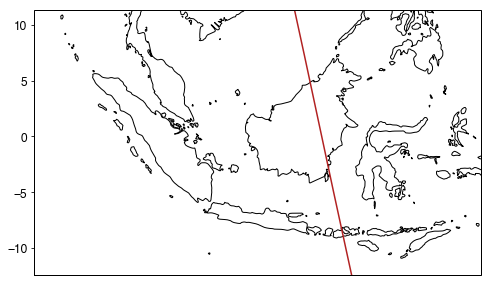

In [3]:
ds = xarray.open_dataset(npy_file_list[0])

lat = ds['Latitude'].sel(fakeDim3=1).values
lon = ds['Longitude'].sel(fakeDim5=1).values


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

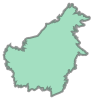

In [4]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]

list(borneo_gdf_union.geoms)[15]

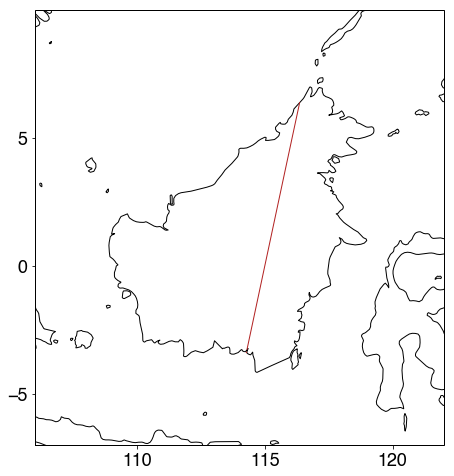

In [5]:
fontsize=18
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([106,122,-7,10])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

track_geom_crop_list = []
for file in [npy_file_list[9]]:
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].sel(fakeDim3=1).values
    lon = ds['Longitude'].sel(fakeDim5=1).values
    ds.close()
    
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    track_geom_crop = track_geom.intersection(borneo_main_geom)
    
    track_geom_crop_list.append(track_geom_crop)
    
    if type(track_geom_crop)!='list':
        ax.add_geometries([track_geom_crop], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick')
    else:
        ax.add_geometries(track_geom_crop, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick')

ax.set_yticks([-5,0,5])
ax.set_xticks([110,115,120])
ax.tick_params(labelsize=fontsize)

In [6]:
#for file in [npy_file_list[0]]:
file = npy_file_list[9]
ds = xarray.open_dataset(file)

lon = ds['Longitude'].sel(fakeDim5=1).values
lat = ds['Latitude'].sel(fakeDim3=1).values
p_data = ds['Pressure'].values

track_geom = shapely.geometry.LineString(zip(lon,lat))
track_geom_crop = track_geom.intersection(borneo_main_geom)

ds.close()

# open stuff in gdal to get proper values...
gdal_file = gdal.Open(file)
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
gdal_cmsp_ds = gdal.Open(gdal_subdatasets[43][0]) # Cloud_Multiple_Scattering_Profile_532

gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_cmsp_data = gdal_cmsp_ds.ReadAsArray()

gdal_tbc_data[gdal_tbc_data<0] = numpy.nan

# crop stuff

if type(track_geom_crop)==shapely.geometry.linestring.LineString:
    lon_crop,lat_crop = track_geom_crop.coords.xy
    lat_crop = numpy.array(lat_crop)
    lon_crop = numpy.array(lon_crop)
elif type(track_geom_crop)==shapely.geometry.multilinestring.MultiLineString:
    #collect all x coords into array
    lon_crop = numpy.hstack( [linestring.coords.xy[0] for linestring in list(track_geom_crop)] )
    lat_crop = numpy.hstack( [linestring.coords.xy[1] for linestring in list(track_geom_crop)] )

lon_left = lon_crop[0]
lon_right = lon_crop[-1]

lon_left_idx = numpy.abs(lon-lon_left).argmin()
lon_right_idx = numpy.abs(lon-lon_right).argmin()

lon_subset = lon[lon_left_idx:lon_right_idx+1]
lat_subset = lat[lon_left_idx:lon_right_idx+1]

p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))

gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]
gdal_clf_data_subset = gdal_clf_data[lon_left_idx:lon_right_idx+1]
gdal_cmsp_data_subset = gdal_cmsp_data[lon_left_idx:lon_right_idx+1]

### interpolate

In [9]:
xnew = numpy.arange(-5,7.001,0.01)
ynew = numpy.arange(113.25,1013.251,0.1)

def interpolate_and_save_calipso_data(file, xnew, ynew, intersection_geometry):
    
    print(file)
    
    ds = xarray.open_dataset(file)
    lon = ds['Longitude'].sel(fakeDim5=1).values
    lat = ds['Latitude'].sel(fakeDim3=1).values
    p_data = ds['Pressure'].values
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    track_geom_crop = track_geom.intersection(intersection_geometry)
    ds.close()
    
    # open stuff in gdal to get proper values...
    gdal_file = gdal.Open(file)
    gdal_subdatasets = gdal_file.GetSubDatasets()
    gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
    gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
    gdal_tbc_data[gdal_tbc_data<0] = numpy.nan
    # crop stuff
    if type(track_geom_crop)==shapely.geometry.linestring.LineString:
        lon_crop,lat_crop = track_geom_crop.coords.xy
        lat_crop = numpy.array(lat_crop)
        lon_crop = numpy.array(lon_crop)
    elif type(track_geom_crop)==shapely.geometry.multilinestring.MultiLineString:
        #collect all x coords into array
        lon_crop = numpy.hstack( [linestring.coords.xy[0] for linestring in list(track_geom_crop)] )
        lat_crop = numpy.hstack( [linestring.coords.xy[1] for linestring in list(track_geom_crop)] )
    lon_left = lon_crop[0]
    lon_right = lon_crop[-1]
    lon_left_idx = numpy.abs(lon-lon_left).argmin()
    lon_right_idx = numpy.abs(lon-lon_right).argmin()
    lon_subset = lon[lon_left_idx:lon_right_idx+1]
    lat_subset = lat[lon_left_idx:lon_right_idx+1]
    p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
    lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))
    gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]

    z = gdal_tbc_data_subset.ravel()
    x = lat_2d.ravel()
    y = p_data_subset.ravel()

    try:
        gdal_tbc_data_interpolated = scipy.interpolate.griddata((x,y),z, \
                                                                (xnew[None,:],ynew[:,None]), \
                                                                method='linear')
    except:
            gdal_tbc_data_interpolated = scipy.interpolate.griddata((x,y),z, \
                                                                    (xnew[None,:],ynew[:,None]), \
                                                                    method='nearest')
    
    # get date from file
    file_date = file.split('.')[-2][:-2]
    file_datetime = datetime.datetime.strptime(file_date, '%Y-%m-%dT%H-%M-%S')

    # create dictionary, DataArray, and DataSet
    coords_dict = {'time':[pandas.to_datetime(file_datetime)], \
                   'pressure':ynew, \
                   'lat':xnew}

    data_array = xarray.DataArray(gdal_tbc_data_interpolated[None,:,:], \
                                  coords=coords_dict, \
                                  dims=('time','pressure','lat'))

    save_as_name = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA_PROCESSED/BORNEO_LANDMASS/'+\
    file.split('.')[-2]+\
    '_total_backscatter_coefficient_interpolated.nc'

    save_ds = xarray.Dataset({'gdal_tbc_data_interpolated':data_array})
    save_ds.to_netcdf(save_as_name, unlimited_dims='time')
    save_ds.close()
    
    return(file)

In [10]:
#npy_file_list.index('/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2008-12-22T05-13-27ZD.hdf')
npy_file_list.index('/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2008-05-28T05-24-09ZD.hdf')

files_that_fail = [612,787]



In [11]:
joblib_result = joblib.Parallel(n_jobs=30, verbose=10)\
(joblib.delayed(interpolate_and_save_calipso_data)(file,xnew,ynew,borneo_main_geom)\
 for file in npy_file_list)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:   24.3s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   25.2s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:   27.4s
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:   40.8s
[Parallel(n_jobs=30)]: Done  53 tasks      | elapsed:   43.8s
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:   53.3s
[Parallel(n_jobs=30)]: Done  85 tasks      | elapsed:   57.4s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done 121 tasks      | elapsed:  1.2min
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 161 tasks      | elapsed:  1.6min
[Parallel(n_jobs=30)]: Done 182 tasks      | elapsed:  1.7min
[Parallel(n_jobs=30)]: Done 205 tasks      | elapsed:  1.9min
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:  2.1min
[Parallel(n_jobs=30)]: Done 253 tasks      | elapsed:  

# inspecting results

In [35]:
!ls nc_files_interpolated/* | wc


   3591    3591  323190


In [36]:
nc_file_list = sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA_PROCESSED/BORNEO_LANDMASS/*'))

In [37]:
ds = xarray.open_dataset(nc_file_list[-1])

vals = ds['gdal_tbc_data_interpolated'].isel(time=0).values

In [38]:
step = 1e-4
one = numpy.arange(1e-4,9e-4+step,step)
step = 0.5e-3
two = numpy.arange(1e-3,8e-3+step,step)
step = 1e-2
three = numpy.arange(1e-2,1e-1+step,step)
bounds = list(numpy.concatenate((one,two,three)))

cmap = matplotlib.cm.Spectral
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make color map
minval=0. # for inferno:  0.18
maxval=0.9 # for inferno: 1.0
n=256
full_cmap = cmocean.cm.ice_r #mp.get_cmap('blues')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [ ]:
fig = mp.figure(figsize=(8,8))
ax = fig.add_subplot(211)
plot = ax.pcolormesh(xnew,ynew,vals, norm=norm, cmap=cmap_partial)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

# troubleshooting version?

In [ ]:
xnew = numpy.arange(-5,7.001,0.01)
ynew = numpy.arange(113.25,1013.251,0.1)
xnewmesh,ynewmesh = numpy.meshgrid(xnew,ynew,indexing='ij')

def interpolate_and_save_calipso_data(file, xnew, ynew, intersection_geometry):

    print(file)
    
    ds = xarray.open_dataset(file)
    lon = ds['Longitude'].sel(fakeDim5=1).values
    lat = ds['Latitude'].sel(fakeDim3=1).values
    p_data = ds['Pressure'].values
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    track_geom_crop = track_geom.intersection(intersection_geometry)
    ds.close()
    
    # open stuff in gdal to get proper values...
    gdal_file = gdal.Open(file)
    gdal_subdatasets = gdal_file.GetSubDatasets()
    gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
    gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
    gdal_tbc_data[gdal_tbc_data<0] = numpy.nan
    
    # crop stuff
    if type(track_geom_crop)==shapely.geometry.linestring.LineString:
        lon_crop,lat_crop = track_geom_crop.coords.xy
        lat_crop = numpy.array(lat_crop)
        lon_crop = numpy.array(lon_crop)
    elif type(track_geom_crop)==shapely.geometry.multilinestring.MultiLineString:
        #collect all x coords into array
        lon_crop = numpy.hstack( [linestring.coords.xy[0] for linestring in list(track_geom_crop)] )
        lat_crop = numpy.hstack( [linestring.coords.xy[1] for linestring in list(track_geom_crop)] )
    lon_left = lon_crop[0]
    lon_right = lon_crop[-1]
    lon_left_idx = numpy.abs(lon-lon_left).argmin()
    lon_right_idx = numpy.abs(lon-lon_right).argmin()
    lon_subset = lon[lon_left_idx:lon_right_idx+1]
    lat_subset = lat[lon_left_idx:lon_right_idx+1]
    p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
    lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))
    gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]

    z = gdal_tbc_data_subset.ravel()
    x = lat_2d.ravel()
    y = p_data_subset.ravel()

#    try:
    gdal_tbc_data_interpolated = scipy.interpolate.griddata((x,y),z, (xnew[None,:],ynew[:,None]), method='linear')
#     except QhullError:
#         print('QhullError:  changing to all NaNs')
#         gdal_tbc_data_interpolated = numpy.ones((ynew.size,xnew.size))*numpy.nan

    # get date from file
    file_date = file.split('.')[-2][:-2]
    file_datetime = datetime.datetime.strptime(file_date, '%Y-%m-%dT%H-%M-%S')

    # create dictionary, DataArray, and DataSet
    coords_dict = {'time':[pandas.to_datetime(file_datetime)], \
                   'pressure':ynew, \
                   'lat':xnew}

    data_array = xarray.DataArray(gdal_tbc_data_interpolated[None,:,:], \
                                  coords=coords_dict, \
                                  dims=('time','pressure','lat'))

    save_as_name = './nc_files_interpolated/'+file.split('.')[-2]+'_total_backscatter_coefficient_interpolated.nc'

    save_ds = xarray.Dataset({'gdal_tbc_data_interpolated':data_array})
    save_ds.to_netcdf(save_as_name)
    save_ds.close()
    
    return(file)

#file = npy_file_list[0]
file = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2008-05-28T05-24-09ZD.hdf'
interpolate_and_save_calipso_data(file,xnew,ynew,borneo_main_geom)

In [74]:
!ls nc_files_interpolated/* | wc

    632     632   56880


# plotting

In [76]:
step = 1e-4
one = numpy.arange(1e-4,9e-4+step,step)
step = 0.5e-3
two = numpy.arange(1e-3,8e-3+step,step)
step = 1e-2
three = numpy.arange(1e-2,1e-1+step,step)
bounds = list(numpy.concatenate((one,two,three)))

cmap = matplotlib.cm.Spectral
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make color map
minval=0. # for inferno:  0.18
maxval=0.9 # for inferno: 1.0
n=256
full_cmap = cmocean.cm.ice_r #mp.get_cmap('blues')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

(1013.25, 50)

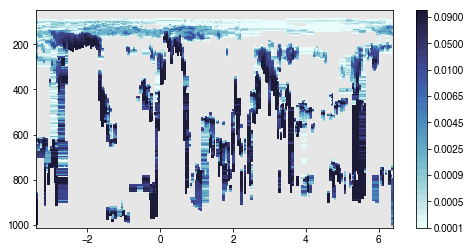

In [62]:
file = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2008-05-28T05-24-09ZD.hdf'
    
ds = xarray.open_dataset(file)
lon = ds['Longitude'].sel(fakeDim5=1).values
lat = ds['Latitude'].sel(fakeDim3=1).values
p_data = ds['Pressure'].values
track_geom = shapely.geometry.LineString(zip(lon,lat))
track_geom_crop = track_geom.intersection(borneo_main_geom)
ds.close()

# open stuff in gdal to get proper values...
gdal_file = gdal.Open(file)
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
gdal_tbc_data[gdal_tbc_data<0] = numpy.nan

fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(lat_2d.T[::-1,:], p_data_subset.T[::-1,:], gdal_tbc_data_subset.T[::-1,:], norm=norm, cmap=cmap_partial)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)